# **Dự Đoán Giá Nhà từ Dữ Liệu Bất Động Sản ở Hà Nội (tuần 4)**

Ở bài trước, chúng ta đã chạy được lan truyền xuôi dựa trên tập dữ liệu bất động sản ở Hà Nội. Trong bài tập này, chúng ta sẽ đi sâu hơn về phần huấn luyện mô hình.

**Dữ Liệu**:

Chúng ta sẽ sử dụng tập dữ liệu về dự đoán giá nhà được lấy từ Kaggle (https://www.kaggle.com/datasets/ladcva/vietnam-housing-dataset-hanoi/data). Tập dữ liệu này chứa thông tin về các giao dịch bất động sản ở Hà Nội, bao gồm các thuộc tính liên quan như địa chỉ, quận, huyện, diện tích, số phòng ngủ,... và giá bán. Mục tiêu của chúng ta là xây dựng một mô hình để dự đoán giá của các căn nhà dựa trên các thuộc tính này.

**Phương Pháp**:

Chúng ta sẽ tiến hành các bước sau:
* Normalization
* Gradient clipping
* Adam optimizer
* Learning rate decay

# Tải các dữ liệu đầu vào

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Vì bài tập tuần 1 chỉ tập trung vào lan truyền xuôi, chúng ta sẽ tải những dữ liệu và thông số đã được xử lý. Đầu tiên chúng ta sẽ tải các biến đã được xử lý vào notebook (X_train, y_train, X_test, y_test). Trong đó:
- Train (Dữ liệu huấn luyện): Dùng để dạy mô hình học từ dữ liệu, với X_train là biến đầu vào và y_train là nhãn đầu ra.
- Test (Dữ liệu kiểm tra): Dùng để đánh giá hiệu suất của mô hình sau khi huấn luyện, với X_test là biến đầu vào và y_test là nhãn đầu ra.

Giải thích thư viện: **NumPy** (`import numpy as np`):
   - **Mục đích**: NumPy là thư viện nền tảng cho tính toán khoa học trong Python.
   - **Chức năng chính**: Cung cấp các mảng (arrays) và ma trận (matrices) đa chiều hiệu suất cao, cùng với các hàm toán học để thao tác với chúng.

In [ ]:
import numpy as np

# Load the x and y arrays from .npy files
x = np.load('/content/drive/MyDrive/notebook/original_x.npy')
y = np.load('/content/drive/MyDrive/notebook/original_y.npy')

# Verify the shapes of x and y
print(f"Shape of x: {x.shape}")
print(f"Shape of y: {y.shape}")

Shape of x: (75074, 6)
Shape of y: (75074,)


# Các hàm ở bài tập trước

## Hàm ReLU

Hàm này là hàm kích hoạt ReLU (Rectified Linear Activation Function), được định nghĩa bằng công thức:

ReLU(x) = max(0, x)

Hàm này trả về giá trị của x nếu x lớn hơn hoặc bằng 0, và trả về 0 nếu x nhỏ hơn 0. Điều này làm cho hàm ReLU trở thành một hàm phi tuyến tính, giúp nó hoạt động tốt trong việc giải quyết vấn đề biến mất đạo hàm và tăng cường hiệu suất của mạng nơ-ron.

In [4]:
import numpy as np

# Định nghĩa hàm kích hoạt ReLU
def relu(x):
    """
    Hàm kích hoạt ReLU (Rectified Linear Unit).

    Hàm ReLU là một hàm phi tuyến tính thường được sử dụng trong các mạng neural.
    Nó thay thế tất cả các giá trị âm trong đầu vào bằng 0 và giữ nguyên các giá trị dương.

    Tham số:
    x -- đầu vào dưới dạng mảng NumPy (numpy array), có thể là một số, vector, hoặc ma trận.

    Trả về:
    Hàm ReLU trả về mảng cùng kích thước với đầu vào, trong đó các giá trị âm đã bị thay thế bằng 0.
    """
    return np.maximum(0, x)

## Tính độ mất mát
Trong cell này, chúng ta định nghĩa hàm compute_cost để tính toán độ mất mát của mô hình bằng phương pháp Mean Squared Error (MSE).

In [5]:
# Tính toán độ mất mát (mean squared error)
def compute_cost(A, Y):
    """
    Tính toán lỗi bình phương trung bình.

    Tham số:
    A -- Đầu ra của kích hoạt cuối cùng, có dạng (1, số lượng ví dụ)
    Y -- vector nhãn "thật" có dạng (1, số lượng ví dụ)

    Trả về:
    cost -- lỗi bình phương trung bình
    """
    m = Y.shape[1]
    cost = (1.0 / m) * np.sum(np.square(A - Y))
    return float(np.squeeze(cost))

## Lan truyền ngược
Trong cell này, chúng ta định nghĩa hàm backward_propagation để thực hiện lan truyền ngược cho một lớp của mạng neural. Lan truyền ngược giúp tính toán gradient của hàm mất mát đối với các tham số của mạng, qua đó cập nhật trọng số và bias để tối ưu hóa mô hình.

In [6]:
# Lan truyền ngược (một lớp)
def backward_propagation(dA, cache, activation):
    """
    Thực hiện lan truyền ngược qua một lớp của mạng neural.

    Hàm này tính toán gradient của hàm mất mát đối với các tham số của lớp (trọng số và bias)
    và gradient đối với đầu vào của lớp đó. Đây là bước cần thiết để cập nhật các tham số trong quá trình huấn luyện.

    Tham số:
    dA -- Gradient của hàm mất mát đối với đầu ra của lớp hiện tại, có kích thước (số lượng đơn vị lớp hiện tại, số lượng ví dụ).
    cache -- Dictionary chứa các giá trị cần thiết cho lan truyền ngược, bao gồm:
        - "Z" -- Giá trị trước kích hoạt của lớp hiện tại.
        - "A_prev" -- Đầu vào của lớp hiện tại.
        - "W" -- Trọng số của lớp hiện tại.
        - "A" -- Đầu ra của lớp hiện tại sau khi áp dụng hàm kích hoạt.
    activation -- Loại hàm kích hoạt, có thể là "relu" hoặc "linear".

    Trả về:
    dA_prev -- Gradient của hàm mất mát đối với đầu vào của lớp hiện tại, có kích thước (số lượng đặc trưng, số lượng ví dụ).
    dW -- Gradient của hàm mất mát đối với ma trận trọng số của lớp hiện tại.
    db -- Gradient của hàm mất mát đối với vector bias của lớp hiện tại.
    """
    Z = cache["Z"]

    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    elif activation == "linear":
        dZ = dA  # Đối với kích hoạt tuyến tính, dZ = dA
    else:
        raise ValueError("Hàm kích hoạt không được hỗ trợ")

    A_prev = cache["A_prev"]
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(cache["W"].T, dZ)

    return dA_prev, dW, db

## Khởi tạo thông số
Trong cell này, chúng ta định nghĩa hàm initialize_parameters để khởi tạo các tham số cho một lớp của mạng neural. Hàm này sẽ khởi tạo trọng số (W) sử dụng phương pháp He Normal initialization và bias (b) với giá trị 0.

In [7]:
# Khởi tạo tham số thông thường
def initialize_parameters(input_dim, units):
    """
    Khởi tạo trọng số với khởi tạo thông thường (Gaussian với phương sai nhỏ) và bias với giá trị 0.

    Tham số:
    input_dim -- kích thước của lớp đầu vào
    units -- số lượng đơn vị trong lớp

    Trả về:
    parameters -- dictionary chứa các tham số:
                    W -- ma trận trọng số có dạng (units, input_dim)
                    b -- vector bias có dạng (units, 1)
    """
    W = np.random.randn(units, input_dim) * 0.01  # Khởi tạo thông thường với giá trị nhỏ
    b = np.zeros((units, 1))
    parameters = {"W": W, "b": b}
    return parameters

# BÀI TẬP: Chuẩn hóa dữ liệu (normalization)

Quá trình chuẩn hóa dữ liệu liên quan đến việc biến đổi dữ liệu để mỗi thuộc tính (feature) có giá trị trung bình bằng 0 và độ lệch chuẩn bằng 1. Đây là một bước quan trọng trong tiền xử lý dữ liệu để đảm bảo rằng tất cả các thuộc tính đóng góp đồng đều vào mô hình học máy và tránh việc một thuộc tính chi phối các thuộc tính khác.

## Công thức chuẩn hóa

Để chuẩn hóa một thuộc tính $x_i$ (giá trị của thuộc tính ở hàng thứ \(i\)):

$x_i' = \frac{x_i - \mu}{\sigma}$

Trong đó:
- $x_i'$ là giá trị đã được chuẩn hóa của $x_i$.
- $\mu$ là giá trị trung bình của tất cả các giá trị trong thuộc tính đó.
- $\sigma$ là độ lệch chuẩn của tất cả các giá trị trong thuộc tính đó.

## Các bước thực hiện

1. **Tính giá trị trung bình ($\mu$)** cho từng thuộc tính:
   $\mu = \frac{1}{n} \sum_{i=1}^{n} x_i$
   Trong đó $n$ là số lượng mẫu.

2. **Tính độ lệch chuẩn ($\sigma$)** cho từng thuộc tính:
   $\sigma = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2}$

3. **Chuẩn hóa** từng giá trị của thuộc tính:
   $x_i' = \frac{x_i - \mu}{\sigma}$

Bằng cách thực hiện các bước trên, tất cả các thuộc tính của dữ liệu sẽ có trung bình bằng 0 và độ lệch chuẩn bằng 1, giúp mô hình học máy hoạt động hiệu quả hơn.

Gợi ý:
* Trung bình có thể được tính bằng hàm [numpy.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)
* Độ lệch chuẩn có thể được tính bằng hàm [numpy.std](https://numpy.org/doc/stable/reference/generated/numpy.std.html)

In [8]:
def normalization(x):
    '''
    Chuẩn hóa dữ liệu bằng cách trừ đi giá trị trung bình và chia cho độ lệch chuẩn của từng thuộc tính.

    Tham số:
    x -- mảng numpy chứa dữ liệu cần chuẩn hóa, có hình dạng (số_lượng_examples, số_lượng_features)

    Trả về:
    x_normalized -- mảng numpy chứa dữ liệu đã được chuẩn hóa, có cùng hình dạng với đầu vào
    mean -- mảng numpy chứa giá trị trung bình của từng thuộc tính, có hình dạng (số_lượng_features, )
    std -- mảng numpy chứa độ lệch chuẩn của từng thuộc tính, có hình dạng (số_lượng_features, )
    '''
    ### BEGIN SOLUTION
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    x_normalized = (x - mean) / std
    ### END SOLUTION
    return x_normalized, mean, std

In [9]:
# Tests 10 points.

x1 = np.array([[1, 2], [3, 4], [5, 6]])
normalized_x1, temp_mean, temp_std = normalization(x1.copy())
assert np.allclose(normalized_x1.mean(axis=0), 0, atol=1e-7), "Test 1 sai: Trung bình khác 0."
assert np.allclose(normalized_x1.std(axis=0), 1, atol=1e-7), "Test 1 sai: Độ lệch chuẩn khác 1."

### BEGIN HIDDEN TESTS

# Test 2: Array with negative values
x2 = np.array([[-1, -2], [-3, -4], [-5, -6]])
normalized_x2, temp_mean, temp_std = normalization(x2.copy())
assert np.allclose(normalized_x2.mean(axis=0), 0, atol=1e-7), "Test 2 failed: Mean is not zero."
assert np.allclose(normalized_x2.std(axis=0), 1, atol=1e-7), "Test 2 failed: Standard deviation is not one."

# Test 3: Array with mixed values
x3 = np.array([[1, -1], [2, -2], [3, -3]])
normalized_x3, temp_mean, temp_std = normalization(x3.copy())
assert np.allclose(normalized_x3.mean(axis=0), 0, atol=1e-7), "Test 3 failed: Mean is not zero."
assert np.allclose(normalized_x3.std(axis=0), 1, atol=1e-7), "Test 3 failed: Standard deviation is not one."

### END HIDDEN TESTS

In [10]:
x_normalized, mean, std = normalization(x)

In [11]:
x_normalized

array([[-0.98443252, -0.38611126,  0.43489474,  0.77770389, -0.02255992,
        -1.10025004],
       [ 0.74864915, -0.79891509, -1.6646029 , -0.60181414, -0.16567025,
        -0.7286822 ],
       [-0.73684943, -0.51745793,  0.43489474,  0.08794487, -0.1179668 ,
        -0.36828932],
       ...,
       [-0.98443252,  0.2330945 , -1.6646029 ,  0.08794487, -0.10206566,
        -0.16993356],
       [-0.98443252,  0.2330945 ,  0.43489474,  0.08794487,  0.20005616,
         0.33014647],
       [-0.98443252, -0.55498555,  2.53439239,  0.08794487, -0.03846106,
        -0.82646321]])

Chia dữ liệu thành các tập huấn luyện và kiểm tra (training và test datasets) sử dụng hàm train_test_split() từ thư viện sklearn.model_selection theo tỉ lệ 70% cho training và 30% cho testing.

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

# Giả định rằng x_normalized và y đã được định nghĩa và chuẩn hóa trước đó
# x_normalized: Ma trận đặc trưng đã được chuẩn hóa (normalized features matrix)
# y: Vector mục tiêu (target vector)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# test_size=0.3: 30% dữ liệu được sử dụng cho tập kiểm tra
# random_state=0: Đảm bảo rằng việc chia dữ liệu là ngẫu nhiên nhưng có thể tái lập
X_train, X_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.3, random_state=0)

# Output:
# X_train: Ma trận đặc trưng cho tập huấn luyện
# X_test: Ma trận đặc trưng cho tập kiểm tra
# y_train: Vector mục tiêu cho tập huấn luyện
# y_test: Vector mục tiêu cho tập kiểm tra

In [13]:
# In ra kích thước của X_test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(52551, 6)
(52551,)
(22523, 6)
(22523,)


# BÀI TẬP: Dropout

Dropout là một kỹ thuật thường được sử dụng trong mạng neural để giảm thiểu *overfitting*. Trong quá trình huấn luyện, dropout làm tắt ngẫu nhiên một số neuron tại mỗi lớp bằng cách nhân đầu ra của các neuron này với 0. Mỗi neuron có xác suất `keep_prob` để được giữ lại. Dropout mask \( D \) (chứa các giá trị 0 hoặc 1) quyết định neuron nào sẽ hoạt động trong lượt lan truyền xuôi. Sau khi áp dụng dropout, giá trị đầu ra \( A \) được chia cho `keep_prob` để giữ nguyên kỳ vọng đầu ra. Điều này giúp mạng học cách dựa vào nhiều neuron hơn, tăng cường khả năng tổng quát hoá khi gặp dữ liệu mới.

## Dropout trong lan truyền xuôi

Dropout giúp làm tắt ngẫu nhiên một số neuron trong lớp hiện tại, giúp mạng tránh *overfitting*. Khi áp dụng dropout, ta thực hiện các bước sau:

1. **Tạo Dropout Mask**:
   - Dropout mask $D$ là một ma trận nhị phân (0 hoặc 1), có cùng kích thước với đầu ra của lớp, trong đó mỗi phần tử của $D$ sẽ là 1 với xác suất bằng `keep_prob` và 0 với xác suất $1 - \text{keep_prob}$.
   - Ta tạo $D$ bằng cách:
    \begin{equation*}
      D_{i,j} =
      \begin{cases}
      1, & \text{nếu } r_{i,j} < \text{keep_prob} \\
      0, & \text{nếu } r_{i,j} \geq \text{keep_prob}
      \end{cases}
    \end{equation*}

Trong đó:
- $D_{i,j}$ là phần tử tại hàng $i$, cột $j$ của dropout mask $D$.
- $r_{i,j}$ là một số ngẫu nhiên được lấy từ phân phối đều trên khoảng [0, 1].
- `keep_prob` là xác suất giữ lại một neuron (nghĩa là, xác suất mà $D_{i,j} = 1$).

Nói cách khác, mỗi phần tử của $D$ là 1 với xác suất `keep_prob` và 0 với xác suất $1 - \text{keep_prob}$.
   - Trong đó $\mathbb{1}$ là hàm chỉ báo, giúp gán giá trị 1 cho những phần tử có xác suất nhỏ hơn `keep_prob`.

2. **Áp dụng Dropout Mask**:
   - Sau khi tạo $D$, ta nhân $D$ với đầu ra $A$ của lớp:
     \begin{equation*}
     A = A \odot D
     \end{equation*}
   - Ở đây, $\odot$ là phép nhân từng phần tử, giúp làm tắt (đặt giá trị bằng 0) những neuron có mask $D$ bằng 0.

3. **Chuẩn hóa Đầu Ra**:
   - Sau khi áp dụng dropout mask, để đảm bảo kỳ vọng của $A$ không thay đổi, ta chia $A$ cho `keep_prob`:
     \begin{equation*}
     A = \frac{A}{\text{keep_prob}}
     \end{equation*}
   - Điều này giúp giữ cho giá trị trung bình của đầu ra không bị giảm sút do dropout.

#### Tóm tắt công thức

Với dropout, công thức tính đầu ra $A$ sau khi áp dụng hàm kích hoạt và dropout sẽ là:

\begin{equation*}
A = \frac{(A \odot D)}{\text{keep_prob}}
\end{equation*}

Trong đó:
- $A$ là đầu ra của lớp sau khi qua hàm kích hoạt.
- $D$ là dropout mask với xác suất giữ lại mỗi phần tử là `keep_prob`.
- `keep_prob` là xác suất giữ lại một neuron, thường có giá trị trong khoảng (0, 1].

Gợi ý:

1. Tạo một **dropout mask** `D` với cùng kích thước như `A`, sử dụng [np.random.rand](https://numpy.org/doc/2.0/reference/random/generated/numpy.random.rand.html). Mỗi phần tử của `D` nên có xác suất bằng `keep_prob` để là 1, và xác suất $1 - \text{keep_prob}$ để là 0.

2. **Nhân** đầu ra `A` với mask `D` để làm tắt các neuron theo ý muốn.

3. **Chia** `A` cho `keep_prob` để điều chỉnh lại giá trị kỳ vọng của đầu ra, giúp mạng hoạt động ổn định ngay cả khi sử dụng dropout.

In [27]:
def forward_propagation(A_prev, parameters, activation, keep_prob=1.0):
    """
    Thực hiện lan truyền xuôi qua một lớp của mạng neural với dropout.

    Tham số:
    A_prev -- Đầu vào của lớp hiện tại, có thể là mảng NumPy với kích thước (số lượng đặc trưng, số lượng ví dụ).
    parameters -- Dictionary chứa các tham số của lớp hiện tại:
        - "W" -- Ma trận trọng số
        - "b" -- Vector bias
    activation -- Loại hàm kích hoạt, có thể là "relu" hoặc "linear"
    keep_prob -- Xác suất giữ lại một neuron (1 - tỉ lệ dropout)

    Trả về:
    A -- Giá trị kích hoạt đầu ra của lớp hiện tại
    cache -- Dictionary chứa các giá trị cần thiết cho lan truyền ngược
    """
    W = parameters["W"]
    b = parameters["b"]
    Z = np.dot(W, A_prev) + b

    if activation == "relu":
        A = relu(Z)
    elif activation == "linear":
        A = Z
    else:
        raise ValueError("Hàm kích hoạt không được hỗ trợ")

    # Áp dụng dropout chỉ khi huấn luyện và keep_prob < 1
    D = np.ones(A.shape)
    if keep_prob < 1.0:
        ### BEGIN SOLUTION
        D = np.random.rand(*A.shape) < keep_prob
        A = np.multiply(A, D)
        A = A / keep_prob  # Scale để giữ kỳ vọng của đầu ra không đổi
        ### END SOLUTION

    # Thêm dropout mask vào cache
    cache = {
        "Z": Z,
        "A": A,
        "W": W,
        "A_prev": A_prev,
        "D": D,
        "keep_prob": keep_prob
    }
    return A, cache

In [29]:
# Tests 10 points.

def test_dropout_functionality():
    input_dim, units = 5, 3
    A_prev = np.random.randn(input_dim, 4)
    params = initialize_parameters(input_dim, units)
    keep_prob = 0.8
    A, cache = forward_propagation(A_prev, params, activation="relu", keep_prob=keep_prob)
    D = cache["D"]
    assert np.all((D == 0) | (D == 1)), "Dropout mask contains values other than 0 or 1."
    dropout_rate = 1 - np.mean(D)
    assert abs(dropout_rate - (1 - keep_prob)) < 0.2, f"Dropout rate is incorrect. Expected {1 - keep_prob}, but got {dropout_rate}"
    print("test_dropout_functionality passed!")

test_dropout_functionality()

### BEGIN HIDDEN TESTS
def test_keep_prob_1():
    input_dim, units = 5, 3
    A_prev = np.random.randn(input_dim, 4)
    params = initialize_parameters(input_dim, units)
    A, cache = forward_propagation(A_prev, params, activation="relu", keep_prob=1.0)
    assert np.array_equal(cache["D"], np.ones(A.shape)), "When keep_prob=1, dropout mask should be all ones."
    print("test_keep_prob_1 passed!")

test_keep_prob_1()
### END HIDDEN TESTS

test_dropout_functionality passed!
test_keep_prob_1 passed!


# Cập nhật tham số Nâng Cao
Trong cell này, chúng ta cập nhật các tham số của mô hình bằng phương pháp gradient descent và áp dụng gradient clipping và Adam để điều chỉnh các giá trị gradient tốt nhất.

## Gradient Clipping
Gradient clipping là một kỹ thuật nhằm kiểm soát độ lớn của các gradient để tránh vấn đề gradient exploding (gradients quá lớn) hoặc gradient vanishing (gradients quá nhỏ). Đây là bước quan trọng để cải thiện hiệu quả và ổn định của việc huấn luyện mạng neural.

### Các Bước Của Gradient Clipping
- **Tính Toán Độ Lớn Gradient**:
  - Tính độ lớn (norm) của gradient trọng số ($dW$) và gradient bias ($db$) bằng cách sử dụng hàm `np.linalg.norm`, tính toán chuẩn Euclidean (L2 norm) của các gradient.

    $ \|dW\| = \sqrt{\sum_{i} dW_i^2} $

    $ \|db\| = \sqrt{\sum_{i} db_i^2} $

- **So Sánh Với Clip Norm**:
  - `clip_norm` là giá trị ngưỡng mà ta muốn giới hạn gradient. Nếu độ lớn của gradient vượt quá `clip_norm`, gradient sẽ được điều chỉnh.
  - Nếu độ lớn của gradient trọng số (`dW_norm`) lớn hơn `clip_norm`, gradient trọng số (`dW`) sẽ được điều chỉnh sao cho độ lớn của nó bằng `clip_norm`.
    \begin{equation*}
    dW := dW \times \frac{clip\_norm}{\|dW\|} \quad \text{if} \quad \|dW\| > clip\_norm
    \end{equation*}

  - Tương tự, nếu độ lớn của gradient bias (`db_norm`) lớn hơn `clip_norm`, gradient bias (`db`) cũng sẽ được điều chỉnh.
    \begin{equation*}
    db := db \times \frac{clip\_norm}{\|db\|} \quad \text{if} \quad \|db\| > clip\_norm
    \end{equation*}

- **Cập Nhật Tham Số**:
  - Cập nhật các trọng số (`W`) và bias (`b`) bằng cách trừ đi gradient đã điều chỉnh, nhân với tốc độ học (`learning_rate`).

    $W := W - \alpha * dW$

    $b := b - \alpha * db$

- **Trả Về Các Tham Số Cập Nhật**:
  - Sau khi cập nhật, tham số `parameters` được gán lại với giá trị trọng số và bias đã được cập nhật.

In [ ]:
def update_parameters_with_clipping(parameters, grads, clip_value=1.0):
    """
    Cập nhật các tham số của mô hình sử dụng kỹ thuật gradient clipping.

    Tham số:
    parameters -- dictionary chứa các trọng số và bias của mô hình
    grads -- dictionary chứa gradient của các trọng số và bias
    clip_value -- giá trị để giới hạn gradient (default: 1.0)

    Trả về:
    parameters -- các tham số sau khi đã được cập nhật
    """
    for layer in parameters:
        for param in ['W', 'b']:
            # Clip gradients
            grads[layer]['d' + param] = np.clip(grads[layer]['d' + param], -clip_value, clip_value)

            # Update parameters
            parameters[layer][param] -= grads[layer]['d' + param]

    return parameters

## Adam Optimizer
Adam (viết tắt của Adaptive Moment Estimation) là một thuật toán tối ưu hóa sử dụng cả hai kỹ thuật Momentum và RMSProp. Adam giữ lại các trung bình trọng số của cả gradient (momentum) và bình phương của gradient (RMSProp), đồng thời sử dụng các hiệu chỉnh độ chệch (bias correction) để tăng độ chính xác của các ước lượng ở giai đoạn đầu của quá trình huấn luyện. Adam rất hiệu quả trong việc tối ưu hóa mạng neural phức tạp và thường được sử dụng trong các mô hình học sâu hiện đại.

### Các Bước Của Adam Optimizer

- **Cập Nhật Biến Động Đầu Tiên (First Moment Estimate - Momentum)**:
  - Với mỗi trọng số ($W$) và bias ($b$), Adam tính toán trung bình có trọng số (moving average) của gradient dựa trên hệ số suy giảm $\beta_1$.
  - Công thức cập nhật biến động đầu tiên cho gradient trọng số ($dW$):
    \begin{equation*}
    v_dW := \beta_1 v_dW + (1 - \beta_1) dW
    \end{equation*}
  - Tương tự với gradient bias ($db$):
    \begin{equation*}
    v_db := \beta_1 v_db + (1 - \beta_1) db
    \end{equation*}
  - Ở đây, $\beta_1$ là hệ số điều chỉnh, thường có giá trị gần 1 (thường là 0.9), để đảm bảo rằng các biến động của gradient được theo dõi ổn định.

- **Cập Nhật Biến Động Thứ Hai (Second Moment Estimate - RMSProp)**:
  - Adam cũng tính toán trung bình có trọng số của bình phương gradient (RMSProp) với hệ số suy giảm $\beta_2$.
  - Công thức cập nhật biến động thứ hai cho gradient trọng số:
    \begin{equation*}
    s_dW := \beta_2 s_dW + (1 - \beta_2) (dW^2)
    \end{equation*}
  - Tương tự với gradient bias:
    \begin{equation*}
    s_db := \beta_2 s_db + (1 - \beta_2) (db^2)
    \end{equation*}
  - Hệ số $\beta_2$ cũng thường gần bằng 1 (thường là 0.999) để giảm thiểu sự thay đổi lớn của các gradient.

- **Hiệu Chỉnh Độ Chệch (Bias Correction)**:
  - Do Adam dựa trên các trung bình có trọng số của gradient, ở giai đoạn đầu các giá trị này có thể bị lệch. Do đó, Adam áp dụng hiệu chỉnh độ chệch cho cả biến động đầu tiên và thứ hai.
  - Hiệu chỉnh cho biến động đầu tiên ($v_{dW}$) của gradient trọng số:
    \begin{equation*}
    v_{dW}^{\text{corrected}} := \frac{v_{dW}}{1 - \beta_1^t}
    \end{equation*}
  - Hiệu chỉnh cho biến động thứ hai ($s_{dW}$) của gradient trọng số:
    \begin{equation*}
    s_{dW}^{\text{corrected}} := \frac{s_{dW}}{1 - \beta_2^t}
    \end{equation*}
  - Tương tự với $v_{db}$ và $s_{db}$ cho gradient bias.

- **Cập Nhật Tham Số**:
  - Sau khi có giá trị hiệu chỉnh, Adam cập nhật trọng số và bias bằng cách chia biến động đầu tiên cho căn bậc hai của biến động thứ hai cộng với một giá trị epsilon rất nhỏ để tránh chia cho 0.
  - Cập nhật tham số trọng số ($W$):
    \begin{equation*}
    W := W - \alpha \frac{v_{dW}^{\text{corrected}}}{\sqrt{s_{dW}^{\text{corrected}}} + \epsilon}
    \end{equation*}
  - Tương tự với bias ($b$):
    \begin{equation*}
    b := b - \alpha \frac{v_{db}^{\text{corrected}}}{\sqrt{s_{db}^{\text{corrected}}} + \epsilon}
    \end{equation*}
  - Ở đây, $\alpha$ là tốc độ học (learning rate) và $\epsilon$ là một giá trị rất nhỏ (thường là $10^{-8}$) để đảm bảo độ ổn định số học.

- **Trả Về Các Tham Số Cập Nhật**:
  - Sau khi cập nhật, tham số `parameters` được gán lại với giá trị trọng số và bias đã được cập nhật.

In [34]:
def initialize_adam(parameters):
    """
    Khởi tạo các tham số cho Adam optimizer.

    Tham số:
    parameters -- dictionary chứa các trọng số và bias của mô hình

    Trả về:
    v -- dictionary lưu trữ trung bình trọng số của gradient theo thời gian
    s -- dictionary lưu trữ trung bình trọng số bình phương của gradient theo thời gian
    """
    v = {}
    s = {}
    for layer in parameters:
        v[layer] = {
            "dW": np.zeros_like(parameters[layer]['W']),  # Khởi tạo giá trị ban đầu cho dW
            "db": np.zeros_like(parameters[layer]['b'])   # Khởi tạo giá trị ban đầu cho db
        }
        s[layer] = {
            "dW": np.zeros_like(parameters[layer]['W']),  # Khởi tạo giá trị ban đầu cho dW (momentum)
            "db": np.zeros_like(parameters[layer]['b'])   # Khởi tạo giá trị ban đầu cho db (momentum)
        }
    return v, s

In [35]:
def update_parameters_adam(parameters, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Cập nhật các tham số sử dụng thuật toán Adam.

    Tham số:
    parameters -- dictionary chứa các trọng số và bias
    grads -- dictionary chứa gradient của trọng số và bias
    v -- dictionary lưu trữ trung bình trọng số của gradient
    s -- dictionary lưu trữ trung bình trọng số bình phương của gradient
    t -- số bước lặp hiện tại
    learning_rate -- tốc độ học (default: 0.01)
    beta1 -- hệ số suy giảm cho v (default: 0.9)
    beta2 -- hệ số suy giảm cho s (default: 0.999)
    epsilon -- giá trị nhỏ để tránh chia cho 0 (default: 1e-8)

    Trả về:
    parameters -- các tham số sau khi được cập nhật
    v -- giá trị cập nhật của v
    s -- giá trị cập nhật của s
    """
    for layer in parameters:
        for param in ['W', 'b']:
            # Update biased first moment estimate
            v[layer]['d' + param] = beta1 * v[layer]['d' + param] + (1 - beta1) * grads[layer]['d' + param]

            # Update biased second raw moment estimate
            s[layer]['d' + param] = beta2 * s[layer]['d' + param] + (1 - beta2) * np.square(grads[layer]['d' + param])

            # Compute bias-corrected first moment estimate
            v_corrected = v[layer]['d' + param] / (1 - beta1**t)

            # Compute bias-corrected second raw moment estimate
            s_corrected = s[layer]['d' + param] / (1 - beta2**t)

            # Update parameters
            parameters[layer][param] -= learning_rate * v_corrected / (np.sqrt(s_corrected) + epsilon)

    return parameters, v, s

## BÀI TẬP: Kết hợp Adam optimizer và Gradient Clipping

Hàm `update_parameters_adam_clipping` cập nhật các tham số của mô hình sử dụng thuật toán Adam kết hợp với gradient clipping để kiểm soát độ lớn gradient. Cụ thể, nó:

1. **Gradient Clipping**: Giới hạn giá trị gradient trong khoảng [-clip_value, clip_value] để tránh gradient quá lớn.
2. **Cập Nhật Adam**: Tính toán biến động thứ nhất (momentum) và biến động thứ hai (RMSProp), sau đó áp dụng hiệu chỉnh độ chệch cho cả hai.
3. **Cập Nhật Tham Số**: Tham số được cập nhật dựa trên các biến động đã hiệu chỉnh, theo công thức Adam.

Hàm trả về các tham số, cùng với biến động đã được cập nhật.

Gợi ý: dựa trên code từ Gradient Clipping và Adam Optimizer.

In [31]:
def update_parameters_adam_clipping(parameters, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, clip_value=1.0):
    """
    Cập nhật các tham số của mô hình sử dụng thuật toán Adam kết hợp với gradient clipping.

    Tham số:
    parameters -- dictionary chứa các trọng số và bias của mô hình
    grads -- dictionary chứa gradient của các trọng số và bias
    v -- dictionary lưu trữ trung bình trọng số của gradient (biến động thứ nhất)
    s -- dictionary lưu trữ trung bình trọng số bình phương của gradient (biến động thứ hai)
    t -- số bước lặp hiện tại
    learning_rate -- tốc độ học (default: 0.01)
    beta1 -- hệ số suy giảm cho v (default: 0.9)
    beta2 -- hệ số suy giảm cho s (default: 0.999)
    epsilon -- giá trị nhỏ để tránh chia cho 0 (default: 1e-8)
    clip_value -- giá trị để giới hạn gradient (default: 1.0)

    Trả về:
    parameters -- các tham số sau khi được cập nhật
    v -- giá trị cập nhật của v
    s -- giá trị cập nhật của s
    """
    for layer in parameters:
        for param in ['W', 'b']:
            ### BEGIN SOLUTION
            # Clip gradients
            grads[layer]['d' + param] = np.clip(grads[layer]['d' + param], -clip_value, clip_value)

            # Update biased first moment estimate
            v[layer]['d' + param] = beta1 * v[layer]['d' + param] + (1 - beta1) * grads[layer]['d' + param]

            # Update biased second raw moment estimate
            s[layer]['d' + param] = beta2 * s[layer]['d' + param] + (1 - beta2) * np.square(grads[layer]['d' + param])

            # Compute bias-corrected first moment estimate
            v_corrected = v[layer]['d' + param] / (1 - beta1**t)

            # Compute bias-corrected second raw moment estimate
            s_corrected = s[layer]['d' + param] / (1 - beta2**t)

            # Update parameters
            parameters[layer][param] -= learning_rate * v_corrected / (np.sqrt(s_corrected) + epsilon)
            ### END SOLUTION

    return parameters, v, s

In [45]:
def test_initialize_adam():
    # Test case 1: Simple one-layer network
    parameters = {
        'layer1': {
            'W': np.random.randn(3, 2),
            'b': np.random.randn(3, 1)
        }
    }
    v, s = initialize_adam(parameters)

    # Check structure
    assert set(v.keys()) == set(parameters.keys())
    assert set(s.keys()) == set(parameters.keys())

    # Check shapes
    assert v['layer1']['dW'].shape == parameters['layer1']['W'].shape
    assert v['layer1']['db'].shape == parameters['layer1']['b'].shape
    assert s['layer1']['dW'].shape == parameters['layer1']['W'].shape
    assert s['layer1']['db'].shape == parameters['layer1']['b'].shape

    # Check initialization to zeros
    assert np.all(v['layer1']['dW'] == 0)
    assert np.all(v['layer1']['db'] == 0)
    assert np.all(s['layer1']['dW'] == 0)
    assert np.all(s['layer1']['db'] == 0)

test_initialize_adam()

### BEGIN HIDDEN TESTS

def test_update_parameters_adam_clipping():
    # Initialize test parameters with larger values
    parameters = {
        'layer1': {
            'W': np.array([[1., 2.], [3., 4.], [5., 6.]]),
            'b': np.array([[1.], [2.], [3.]])
        }
    }

    # Initialize gradients with larger values
    grads = {
        'layer1': {
            'dW': np.array([[2.0, -2.0], [3.0, -3.0], [1.0, -1.0]]),
            'db': np.array([[1.5], [-1.5], [0.5]])
        }
    }

    # Initialize v and s
    v, s = initialize_adam(parameters)

    # Test case 1: Basic update with clipping
    t = 1
    clip_value = 2.0
    learning_rate = 0.1  # Increased learning rate

    # Store initial parameter values
    initial_W = parameters['layer1']['W'].copy()
    initial_b = parameters['layer1']['b'].copy()

    # Perform update
    params_updated, v_updated, s_updated = update_parameters_adam_clipping(
        parameters.copy(), grads, v, s, t,
        learning_rate=learning_rate, beta1=0.9, beta2=0.999,
        epsilon=1e-8, clip_value=clip_value
    )

    # Check gradient clipping
    assert np.all(np.abs(grads['layer1']['dW']) <= clip_value)
    assert np.all(np.abs(grads['layer1']['db']) <= clip_value)

    # Check that parameters were updated (with tolerance)
    assert not np.allclose(params_updated['layer1']['W'], initial_W, rtol=1e-10)
    assert not np.allclose(params_updated['layer1']['b'], initial_b, rtol=1e-10)

    # Check that v and s were updated
    assert not np.all(v_updated['layer1']['dW'] == 0)
    assert not np.all(v_updated['layer1']['db'] == 0)
    assert not np.all(s_updated['layer1']['dW'] == 0)
    assert not np.all(s_updated['layer1']['db'] == 0)

def test_edge_cases():
    # Test case 1: Zero gradients
    parameters = {
        'layer1': {
            'W': np.ones((2, 2)),
            'b': np.ones((2, 1))
        }
    }
    grads = {
        'layer1': {
            'dW': np.zeros((2, 2)),
            'db': np.zeros((2, 1))
        }
    }
    v, s = initialize_adam(parameters)
    t = 1

    initial_params = {k: {p: v.copy() for p, v in layer.items()}
                     for k, layer in parameters.items()}

    # Should handle zero gradients without division by zero
    params_updated, _, _ = update_parameters_adam_clipping(
        parameters.copy(), grads, v, s, t,
        epsilon=1e-8, clip_value=1.0
    )

    # With zero gradients, parameters should remain unchanged
    for layer in parameters:
        for param in ['W', 'b']:
            assert np.array_equal(params_updated[layer][param],
                                initial_params[layer][param])

def test_numerical_stability():
    # Test case 1: Very small gradients
    parameters = {
        'layer1': {
            'W': np.ones((2, 2)),
            'b': np.ones((2, 1))
        }
    }
    grads = {
        'layer1': {
            'dW': np.ones((2, 2)) * 1e-10,
            'db': np.ones((2, 1)) * 1e-10
        }
    }
    v, s = initialize_adam(parameters)
    t = 1

    # Should handle very small values without numerical issues
    params_updated, _, _ = update_parameters_adam_clipping(
        parameters.copy(), grads, v, s, t,
        epsilon=1e-8, clip_value=1.0
    )

    assert np.all(np.isfinite(params_updated['layer1']['W']))
    assert np.all(np.isfinite(params_updated['layer1']['b']))

test_update_parameters_adam_clipping()
test_edge_cases()
test_numerical_stability()
print("All tests passed!")

### END HIDDEN TESTS

All tests passed!


## BÀI TẬP: Learning rate decay

Hàm `learning_rate_decay` tính toán learning rate mới dựa trên learning rate ban đầu và tỉ lệ giảm (decay rate) sau mỗi epoch để làm chậm quá trình học trong quá trình huấn luyện. Kỹ thuật này giúp mô hình ổn định hơn khi tiến gần đến lời giải tối ưu, tránh bước nhảy quá lớn khi cập nhật tham số.

### Các Bước:
1. **Tham Số Đầu Vào**:
   - `initial_learning_rate`: Learning rate ban đầu của quá trình huấn luyện.
   - `decay_rate`: Tỉ lệ giảm của learning rate sau mỗi epoch (giá trị nhỏ hơn 1).
   - `epoch`: Số lượng epoch hiện tại, xác định mức độ điều chỉnh.

2. **Công Thức Cập Nhật**:
   - Learning rate mới được tính bằng công thức:
   \begin{equation*}
   \text{new\_learning\_rate} = \frac{\text{initial\_learning\_rate}}{1 + \text{decay\_rate} \times \text{epoch}}
   \end{equation*}
   - Điều này đảm bảo learning rate giảm dần theo thời gian.

3. **Kết Quả**:
   - Hàm trả về giá trị learning rate mới đã được điều chỉnh theo số epoch.

Sử dụng phương pháp này giúp mô hình học chậm hơn khi số lượng epoch tăng lên, từ đó cải thiện sự hội tụ trong quá trình huấn luyện mạng neural.

In [ ]:
def learning_rate_decay(initial_learning_rate, decay_rate, epoch):
    """
    Tính toán learning rate mới dựa trên decay rate và số epoch hiện tại.

    Tham số:
    initial_learning_rate -- learning rate ban đầu
    decay_rate -- tỉ lệ giảm learning rate (0 < decay_rate < 1)
    epoch -- số epoch hiện tại

    Trả về:
    new_learning_rate -- learning rate mới sau khi áp dụng decay
    """
    return initial_learning_rate / (1 + decay_rate * epoch)

Sau đó, ta sẽ dùng các thông số đã được huấn luyện để dự đoán `y_test` dựa trên `X_test`.

In [ ]:
def predict(X, parameters):
    """
    Thực hiện dự đoán với mạng neural (forward pass) trong phase test.

    Parameters:
    X -- input data, shape (n_x, m)
    parameters -- parameters của mạng neural
    keep_prob -- để là 1.0 trong phase test

    Returns:
    A -- activation của layer cuối cùng
    """
    L = len(parameters)  # số layers
    A = X.T

    # Forward propagation
    for l in range(1, L):
        layer_name = f'layer{l}'
        A, _ = forward_propagation(A, parameters[layer_name], 'relu')  # Không dùng dropout trong test

    # Output layer
    A, _ = forward_propagation(A, parameters[f'layer{L}'], 'linear')

    return A

# Tổng hợp các functions trên để huấn luyện mô hình
Như mô hình ở bài trước, chúng ta sẽ xây dựng mô hình như sau:
* Input layer: một lớp Dense với 6 neurons tương ứng 6 thuộc tính.
* Hidden layers: Thêm 1 lớp Dense với mỗi lớp có 10 neurons và hàm kích hoạt là 'relu'.
* Output layer: Thêm một lớp Dense với 1 neurons (vì đây là bài toán dự đoán giá) mà không có activation function (hàm kích hoạt) (vì đây là bài toán linear regression (dự đoán giá trị liên tục)).

Dưới đây là phần mô tả cập nhật của hàm `nn_model`:

### Quy Trình

1. **Khởi Tạo**

   - **Khởi Tạo Tham Số**:
     - `np.random.seed(2)`: Đảm bảo rằng kết quả có thể lặp lại.
     - `n_x` và `m`: Lấy số lượng đặc trưng và số lượng mẫu từ dữ liệu đầu vào.
     - Khởi tạo các tham số cho lớp ẩn và lớp đầu ra:
       - `parameters['layer1']`: Kích thước $(n_x, n_h)$ cho lớp ẩn.
       - `parameters['layer2']`: Kích thước $(n_h, 1)$ cho lớp đầu ra.

   - **Khởi Tạo Các Biến Cho Adam**:
     - `v, s`: Khởi tạo các biến lưu trữ trung bình của gradient và bình phương gradient cho Adam.

2. **Vòng Lặp Qua Các Epochs**

   - **Cập Nhật Learning Rate**:
     - Sử dụng `learning_rate_decay` để giảm learning rate qua các epochs dựa trên `decay_rate`.

   - **Xử Lý Batch**:
     - **Tách Dữ Liệu Thành Batch**: Lấy dữ liệu theo kích thước batch từ dữ liệu gốc.
     - **Lan Truyền Xuôi**:
       - Tính toán output của lớp ẩn với ReLU và lớp đầu ra với hàm kích hoạt tuyến tính.
     - **Tính Độ Mất Mát**: Tính toán cost cho mỗi batch và cập nhật tổng cost của epoch.
     - **Lan Truyền Ngược**:
       - Tính toán gradient cho các lớp bằng cách sử dụng backward propagation.
     - **Cập Nhật Tham Số**:
       - Sử dụng `update_parameters_adam_clipping` để cập nhật các tham số với Adam optimizer, có áp dụng gradient clipping.

3. **In Kết Quả**:
   - Nếu `print_cost` là `True`, in độ mất mát (cost) và learning rate sau mỗi epoch để theo dõi quá trình huấn luyện.

### Tổng Quan
Hàm `nn_model` triển khai một mô hình mạng neural hai lớp, sử dụng Adam optimizer kết hợp với gradient clipping và decay learning rate. Quá trình huấn luyện được thực hiện qua các epoch với kích thước batch, đồng thời theo dõi sự thay đổi của độ mất mát để điều chỉnh quá trình học.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def nn_model(X, Y, X_test, Y_test, layers_dims, num_epochs=20, batch_size=32, initial_learning_rate=0.0001,
             beta1=0.9, beta2=0.999, epsilon=1e-8,
             clip_value=1.0, decay_rate=0.01, keep_prob=0.1, print_cost=True):
    """
    Implement a multi-layer neural network with Adam optimizer, learning rate decay, and dropout.
    Tracks both training and validation loss.

    Parameters:
    X, Y -- training data and labels
    X_test, Y_test -- validation data and labels
    layers_dims -- array chứa số lượng units cho mỗi layer, ví dụ [n_x, 20, 10, 1]
    """
    np.random.seed(2)
    n_x = X.shape[1]
    m = X.shape[0]
    Y = Y.reshape(1, m)
    Y_test = Y_test.reshape(1, X_test.shape[0])
    L = len(layers_dims) - 1  # số lượng layers

    # Để track history của losses
    train_costs = []
    val_costs = []

    # Khởi tạo parameters cho tất cả các layers
    parameters = {}
    for l in range(1, L + 1):
        layer_name = f'layer{l}'
        parameters[layer_name] = initialize_parameters(layers_dims[l-1], layers_dims[l])

    # Khởi tạo Adam optimizer parameters
    v, s = initialize_adam(parameters)
    t = 0  # Initialize time step for Adam

    for epoch in range(num_epochs):
        epoch_cost = 0
        num_batches = int(m / batch_size)

        # Calculate the current learning rate
        current_learning_rate = learning_rate_decay(initial_learning_rate, decay_rate, epoch)

        for batch in range(num_batches):
            t += 1  # Increment time step
            start = batch * batch_size
            end = min(start + batch_size, m)
            X_batch = X[start:end, :]
            Y_batch = Y[:, start:end]

            # Forward propagation
            caches = {}
            A = X_batch.T

            # Hidden layers với ReLU và dropout
            for l in range(1, L):
                layer_name = f'layer{l}'
                A, cache = forward_propagation(A, parameters[layer_name], 'relu',
                                            keep_prob=keep_prob)
                caches[layer_name] = cache

            # Output layer với Linear activation
            A, cache = forward_propagation(A, parameters[f'layer{L}'], 'linear')
            caches[f'layer{L}'] = cache

            # Compute training cost
            batch_cost = compute_cost(A, Y_batch)
            epoch_cost += batch_cost / num_batches

            # Backward propagation
            grads = {}
            dA = -(Y_batch - A)

            # Output layer
            dA_prev, dW, db = backward_propagation(dA, caches[f'layer{L}'], 'linear')
            grads[f'layer{L}'] = {"dW": dW, "db": db}

            # Hidden layers
            for l in range(L-1, 0, -1):
                layer_name = f'layer{l}'
                dA_prev, dW, db = backward_propagation(dA_prev, caches[layer_name], 'relu')
                grads[layer_name] = {"dW": dW, "db": db}

            # Update parameters using Adam
            parameters, v, s = update_parameters_adam_clipping(
                parameters, grads, v, s, t,
                current_learning_rate, beta1, beta2, epsilon, clip_value
            )

        # Compute validation cost after each epoch
        Y_pred_test = predict(X_test, parameters)
        val_cost = compute_cost(Y_pred_test, Y_test)

        # Store costs
        train_costs.append(epoch_cost)
        val_costs.append(val_cost)

        if print_cost and epoch % 1 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  Training Loss: {epoch_cost:.6f}")
            print(f"  Validation Loss: {val_cost:.6f}")
            print(f"  Learning rate: {current_learning_rate:.6f}")
            print("----------------------------------------")

    # Vẽ đồ thị loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_costs, label='Training Loss')
    plt.plot(val_costs, label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    history = {
        'train_loss': train_costs,
        'val_loss': val_costs
    }

    return parameters, history

Epoch 1/10:
  Training Loss: 6249.846174
  Validation Loss: 3536.339299
  Learning rate: 0.000100
----------------------------------------
Epoch 2/10:
  Training Loss: 3276.262104
  Validation Loss: 954.591778
  Learning rate: 0.000099
----------------------------------------
Epoch 3/10:
  Training Loss: 1459.109682
  Validation Loss: 406.901808
  Learning rate: 0.000098
----------------------------------------
Epoch 4/10:
  Training Loss: 466.601747
  Validation Loss: 181.592226
  Learning rate: 0.000097
----------------------------------------
Epoch 5/10:
  Training Loss: 392.711953
  Validation Loss: 119.784197
  Learning rate: 0.000096
----------------------------------------
Epoch 6/10:
  Training Loss: 577.513268
  Validation Loss: 108.164866
  Learning rate: 0.000095
----------------------------------------
Epoch 7/10:
  Training Loss: 718.462482
  Validation Loss: 103.623253
  Learning rate: 0.000094
----------------------------------------
Epoch 8/10:
  Training Loss: 735.7982

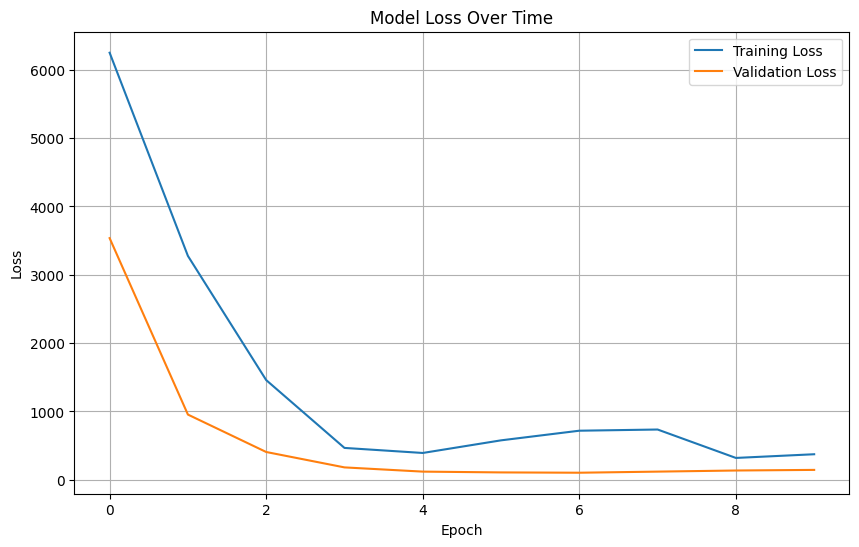

In [ ]:
# Ví dụ sử dụng:
layers_dims = [X_train.shape[1], 128, 16, 1]  # 3 hidden layers
parameters, history = nn_model(X_train, y_train, X_test, y_test,
                             layers_dims=layers_dims,
                             num_epochs=10,
                             batch_size=32,
                             keep_prob=1.0)

Dựa vào các kết quả dự đoán, chúng ta sẽ đánh giá mô hình dựa vào hàm mất mát MSE.

In [ ]:
# Dự đoán giá trị dựa trên X_test và thông số đã được huấn luyện
predictions = predict(X_test, parameters)

# Đánh giá mô hình
mse = compute_cost(predictions, y_test.reshape(1, -1))  # Đổi kích thước y_test để đồng nhất
print("Mean Squared Error trên tệp Test:", mse)

Mean Squared Error trên tệp Test: 0.0005621823359612597


Cuối cùng, để có cái nhìn trực quan hơn về kết quả, chúng ta sẽ in biểu đồ so sánh kết quả thực tế và kết quả dự đoán.

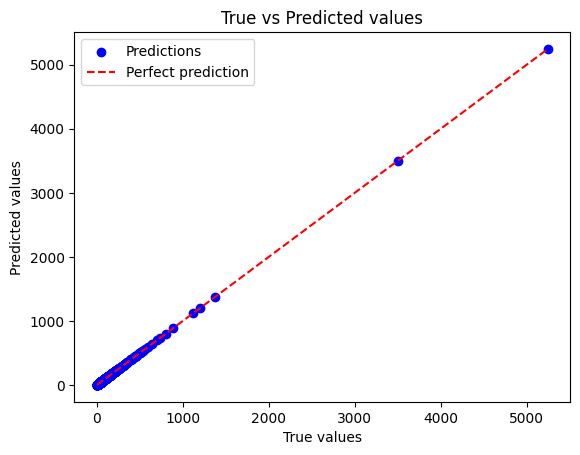

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.scatter(y_test, predictions, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect prediction')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs Predicted values')
plt.legend()
plt.show()

#Thử với data trong dataset

Đầu tiên, ta sẽ lấy 1 data trong X_test và in ra thông tin trong đó.

In [ ]:
x_demo = X_test[0].reshape((1, -1))
print(x_demo)

[[-0.98443252 -1.26801036  0.43489474  1.4674629  -0.1497691  -1.42432425]]


Để chuyển đổi data về giá trị ban đầu, ta cần:

*   Trung bình bằng 0 và độ lệch chuẩn bằng 1
*   LabelEncoder từ thư viện sklearn.preprocessing để chuyển đổi các giá trị trong các cột 'Đường', 'Quận', 'Huyện', và 'Loại hình nhà ở' từ dạng số sang dạng chuỗi.

Đầu tiên, ta cần tải các encoder đã được tạo sẵn (tuần 3) sử dụng thư viện joblib.

In [ ]:
import joblib

# Tải các encoders
quan_label_encoder = joblib.load('/content/drive/MyDrive/notebook/quan_label_encoder.pkl')
huyen_label_encoder = joblib.load('/content/drive/MyDrive/notebook/huyen_label_encoder.pkl')
loai_hinh_nha_o_label_encoder = joblib.load('/content/drive/MyDrive/notebook/loai_hinh_nha_o_label_encoder.pkl')
duong_label_encoder = joblib.load('/content/drive/MyDrive/notebook/duong_label_encoder.pkl')

# Tải giá trị trung bình và độ lệch chuẩn
mean = joblib.load('/content/drive/MyDrive/notebook/mean.pkl')
std = joblib.load('/content/drive/MyDrive/notebook/std.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# Convert x_demo back to original data
x_demo_original = x_demo * std + mean

# Convert categorical features back to original values
quan = quan_label_encoder.inverse_transform([int(x_demo_original[0][0])])[0]
huyen = huyen_label_encoder.inverse_transform([int(x_demo_original[0][1])])[0]
loai_hinh_nha_o = loai_hinh_nha_o_label_encoder.inverse_transform([int(x_demo_original[0][2])])[0]
duong = duong_label_encoder.inverse_transform([int(x_demo_original[0][5])])[0]
so_phong_ngu = int(x_demo_original[0][3])
dien_tich = int(x_demo_original[0][4])

print({'đường': duong, 'quận': quan, 'huyện': huyen, 'loại hình nhà ở': loai_hinh_nha_o, 'số phòng ngủ': so_phong_ngu, 'diện tích': dien_tich})

{'đường': 'cầu giấy', 'quận': 'Quận Cầu Giấy', 'huyện': 'Phường Dịch Vọng', 'loại hình nhà ở': 'Nhà ngõ, hẻm', 'số phòng ngủ': 6, 'diện tích': 38}


Cuối cùng, xem giá nhà dự đoán ở vị trí X_train[0].

In [ ]:
demo_prediction = predict(x_demo, parameters)
print(f"Giá nhà dự đoán {demo_prediction}")
print(f"Giá nhà thực tế {y_test[0]}")

Giá nhà dự đoán [[37.99559592]]
Giá nhà thực tế 38


# Thử với data của bạn

Đầu tiên, ta cần nhập vào input và mã hóa các thông tin của đường, quận, huyện, loại hình nhà ở. Ta sẽ sử dụng LabelEncoder để chuyển hóa dữ liệu từ số sang chữ (giải thích kĩ ở tuần 3).

Lưu ý:
* Chỉ nhập tên đường, không bắt đầu bằng "đường" hoặc "phố".
* Đối với data không được train, cell này sẽ xảy ra lỗi.

In [ ]:
duong = 'minh khai'
quan = 'Quận Hai Bà Trưng'
huyen = 'Phường Minh Khai'
loai = 'Nhà mặt phố, mặt tiền'
so_phong = 6
dien_tich = 50

# Chuyển đổi cột 'Địa chỉ'
duong = duong_label_encoder.transform([duong])[0]

# Chuyển đổi cột 'Quận'
quan = quan_label_encoder.transform([quan])[0]

# Chuyển đổi cột 'Huyện'
huyen = huyen_label_encoder.transform([huyen])[0]

# Chuyển đổi cột 'Loại hình nhà ở'
loai = loai_hinh_nha_o_label_encoder.transform([loai])[0]

Sau đó, chúng ta chuẩn hóa x cho chúng có trung bình bằng 0 và độ lệch chuẩn bằng 1. (giải thích kĩ ở tuần 3)

In [ ]:
input = [[quan, huyen, loai, so_phong, dien_tich, duong]]
input = np.array(input)
input = (input-mean)/std
print(input)

[[-0.73684943 -0.51745793 -1.6646029   1.4674629   0.04104468 -0.36828932]]


Cuối cùng, xem giá nhà dự đoán của bạn.

In [ ]:
input_prediction = predict(input, parameters)
print(input_prediction)

[[49.99545845]]
